# 72-Hour Renewable Energy Forecast (CNN-LSTM) using ENTSO-E Data (1 Month History)


**Important:** 
1. Before running, ensure you have `codegreen-core` installed and a `.codegreencore.config` file in your project root or home directory with your `ENTSOE_token`.
2. This notebook is configured to fetch only **1 month of historical data**. This is likely **insufficient** for training the specified deep learning model effectively and may lead to poor performance or overfitting. For better results, consider using a much longer historical period (e.g., 1-3 years).

In [1]:
# Cell 1: Necessary Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, LSTM, Dense
from datetime import datetime, timedelta

print(f"TensorFlow Version: {tf.__version__}")

C:\Users\anikk\anaconda3\envs\codegreen\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


TensorFlow Version: 2.19.0


In [2]:
# Cell 2: Data Fetching and Preprocessing Configuration
# Import codegreen_core (assuming it's installed and configured)
# If this import fails, the script will stop with an ImportError.
from codegreen_core.data import energy

# --- Data Parameters ---
LOOK_BACK = 72          # Use past 72 hours (3 days) of data to predict
FORECAST_HORIZON = 72   # Predict next 72 hours
N_FEATURES = 1          # We are using only 'renewable_percentage' as the input feature
COUNTRY_CODE = "DE"     # Germany, as per project description
DAYS_HISTORY = 31      # Fetch approximately 1 month of historical data (adjust as needed)

In [3]:
# Cell 3: Data Fetching Function (codegreen-core) ENTSO-E
def get_data_codegreen(country_code, days_history):
    """
    Fetches renewable energy percentage data using codegreen-core. 
    This function will raise an error if data fetching or processing fails at any step.
    """
    end_time = datetime.now()
    start_time = end_time - timedelta(days=days_history) 
    
    print(f"Fetching ENTSO-E data for {country_code} from {start_time.strftime('%Y-%m-%d')} to {end_time.strftime('%Y-%m-%d')} using codegreen_core...")
    
    # Direct call to the energy function. If this fails, an error will be raised.
    data_dict = energy(country_code, start_time, end_time, "generation")
    
    # Basic checks; if these fail, subsequent operations would raise errors anyway.
    if not (data_dict and data_dict.get("data_available") and not data_dict["data"].empty):
        print("Warning: codegreen-core reported no data available or returned empty data.")
        if data_dict and data_dict.get("error"):
            print(f"Message from codegreen-core: {data_dict['error']}")
        print("Please ensure your ENTSOE_token is correctly configured and the API is reachable.")
        print("Returning None. Subsequent steps might fail if they expect data.")
        return None
        
    df = data_dict["data"].copy()
    if not pd.api.types.is_datetime64_any_dtype(df['startTime']):
        df['startTime'] = pd.to_datetime(df['startTime'])
    
    # Timezone handling
    if df['startTime'].dt.tz is None:
        df['startTime'] = df['startTime'].dt.tz_localize('Europe/Berlin') # Assuming source timezone if not specified
        df['startTime'] = df['startTime'].dt.tz_convert('UTC')
    else:
        df['startTime'] = df['startTime'].dt.tz_convert('UTC')

    df = df.set_index('startTime')
    
    if 'percentRenewable' in df.columns:
        df_resampled = df['percentRenewable'].resample('h').mean().ffill().bfill()
        print(f"Successfully fetched and resampled {len(df_resampled)} hourly data points for 'percentRenewable'.")
        return df_resampled.rename('renewable_percentage')
    else:
        print("Warning: Column 'percentRenewable' not found in codegreen_core data.")
        print(f"Available columns: {df.columns.tolist()}")
        print("Returning None. Subsequent steps might fail.")
        return None

In [4]:
# Cell 4: Sequence Creation and Data Splitting Function
def create_sequences(data_values_scaled, look_back, forecast_horizon):
    """Creates sequences of X (input) and y (target) for time series forecasting."""
    X_list, y_list = [], []
    if len(data_values_scaled) < look_back + forecast_horizon:
        print(f"Not enough data to create sequences. Data length: {len(data_values_scaled)}, "
              f"Required: {look_back + forecast_horizon}")
        return np.array(X_list), np.array(y_list)
        
    for i in range(len(data_values_scaled) - look_back - forecast_horizon + 1):
        X_list.append(data_values_scaled[i:(i + look_back)])
        y_list.append(data_values_scaled[(i + look_back):(i + look_back + forecast_horizon)])
    return np.array(X_list), np.array(y_list)

In [5]:
# Cell 5: Load, Prepare, and Split Data
print("Attempting to load data using the 'get_data_codegreen' function...")
renewable_series_data = get_data_codegreen(COUNTRY_CODE, DAYS_HISTORY)

X_train, y_train = np.array([]), np.array([])
X_valid, y_valid = np.array([]), np.array([])
X_test, y_test = np.array([]), np.array([])
scaler = MinMaxScaler(feature_range=(0, 1)) # Initialize scaler here for later use

if renewable_series_data is not None and not renewable_series_data.empty:
    print(f"Original data points fetched: {len(renewable_series_data)}")
    # Scale the data
    data_for_scaling = renewable_series_data.values.reshape(-1, 1)
    scaled_data_values = scaler.fit_transform(data_for_scaling).flatten()

    # Create sequences
    X_seq, y_seq = create_sequences(scaled_data_values, LOOK_BACK, FORECAST_HORIZON)

    MIN_SEQUENCES_FOR_SPLIT = 100 # Need at least some sequences for train/val/test
    if X_seq.shape[0] < MIN_SEQUENCES_FOR_SPLIT:
        print(f"CRITICAL: Only {X_seq.shape[0]} sequences were created from {len(renewable_series_data)} data points.")
        print(f"This is insufficient for training (need at least {MIN_SEQUENCES_FOR_SPLIT}).") 
        print("Consider increasing DAYS_HISTORY or checking data source for issues.")
        # Script will continue, but training might not occur or be effective.
    else:
        X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], N_FEATURES))
        
        # Chronological split for time series
        train_size_idx = int(len(X_seq) * 0.70)
        valid_size_idx = int(len(X_seq) * 0.15)
        
        X_train, y_train = X_seq[:train_size_idx], y_seq[:train_size_idx]
        X_valid, y_valid = X_seq[train_size_idx : train_size_idx + valid_size_idx], y_seq[train_size_idx : train_size_idx + valid_size_idx]
        X_test, y_test = X_seq[train_size_idx + valid_size_idx:], y_seq[train_size_idx + valid_size_idx:]
else:
    print("CRITICAL: No data loaded or data is empty. Cannot proceed with model training.")

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Attempting to load data using the 'get_data_codegreen' function...
Fetching ENTSO-E data for DE from 2025-05-05 to 2025-06-05 using codegreen_core...
Successfully fetched and resampled 744 hourly data points for 'percentRenewable'.
Original data points fetched: 744
X_train shape: (420, 72, 1), y_train shape: (420, 72)
X_valid shape: (90, 72, 1), y_valid shape: (90, 72)
X_test shape: (91, 72, 1), y_test shape: (91, 72)


In [6]:
renewable_series_data

startTime
2025-05-04 23:00:00+00:00    66.0
2025-05-05 00:00:00+00:00    66.0
2025-05-05 01:00:00+00:00    66.0
2025-05-05 02:00:00+00:00    65.0
2025-05-05 03:00:00+00:00    63.0
                             ... 
2025-06-04 18:00:00+00:00    59.0
2025-06-04 19:00:00+00:00    57.0
2025-06-04 20:00:00+00:00    56.0
2025-06-04 21:00:00+00:00    55.0
2025-06-04 22:00:00+00:00    54.0
Freq: h, Name: renewable_percentage, Length: 744, dtype: float64

In [7]:
# Cell 6: Model Definition (User's Architecture Adapted)
def build_solar_model(input_look_back, n_features, forecast_horizon):
    """
    Builds the CNN-LSTM model based on user's architecture.
    """
    input_digit_a = Input(shape=(input_look_back, n_features), name="input_sequence") 
    x = input_digit_a 
    
    x = Conv1D(128, kernel_size=2, padding='causal', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, kernel_size=2, padding='causal', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, kernel_size=2, padding='causal', activation='relu')(x)
    x = BatchNormalization()(x)
    
    out_a = x 

    out_lstm = LSTM(1024, return_sequences=False)(out_a)
    
    out_dense = Dense(1024, activation='relu')(out_lstm)
    out_dense = BatchNormalization()(out_dense)
    output_layer = Dense(forecast_horizon, activation='sigmoid')(out_dense)
    
    solar_model = Model(inputs=input_digit_a, outputs=output_layer)
    solar_model.summary(line_length=120)
    return solar_model

# Build the model
solar_model = None 
if X_train.shape[0] > 0: # Check if there's training data
    solar_model = build_solar_model(LOOK_BACK, N_FEATURES, FORECAST_HORIZON)
else:
    print("Skipping model building as no training data is available.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_sequence (InputLayer)                         │ (None, 72, 1)                          │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv1d (Conv1D)                                     │ (None, 72, 128)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization (BatchNormalization)            │ (None, 72, 128)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv1d_1 (Conv1D)                                   │ (None, 72, 128)                        │                32,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_1 (BatchNormalization)          │ (None, 72, 128)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv1d_2 (Conv1D)                                   │ (None, 72, 128)                        │                32,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_2 (BatchNormalization)          │ (None, 72, 128)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ lstm (LSTM)                                         │ (None, 1024)                           │             4,722,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense (Dense)                                       │ (None, 1024)                           │             1,049,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_3 (BatchNormalization)          │ (None, 1024)                           │                 4,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_1 (Dense)                                     │ (None, 72)                             │                73,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 5,917,896 (22.57 MB)

 Trainable params: 5,915,080 (22.56 MB)

 Non-trainable params: 2,816 (11.00 KB)


--- Starting Model Training ---
Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 467ms/step - loss: 0.2441 - mae: 0.2441 - val_loss: 0.1958 - val_mae: 0.1958
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 450ms/step - loss: 0.1781 - mae: 0.1781 - val_loss: 0.1610 - val_mae: 0.1610
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 437ms/step - loss: 0.1472 - mae: 0.1472 - val_loss: 0.1527 - val_mae: 0.1527
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 438ms/step - loss: 0.1174 - mae: 0.1174 - val_loss: 0.1655 - val_mae: 0.1655
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 451ms/step - loss: 0.1035 - mae: 0.1035 - val_loss: 0.1635 - val_mae: 0.1635
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 445ms/step - loss: 0.1031 - mae: 0.1031 - val_loss: 0.2227 - val_mae: 0.2227
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 449ms/step - loss: 0.1015 - mae: 0.1015 - val_loss: 0.2163 - val_mae: 0.2163
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 442ms/step - loss: 0.0949 - mae: 0.0949 - val_loss: 0.1544 - val_mae: 0.1544
Epoch 9/30
27/2

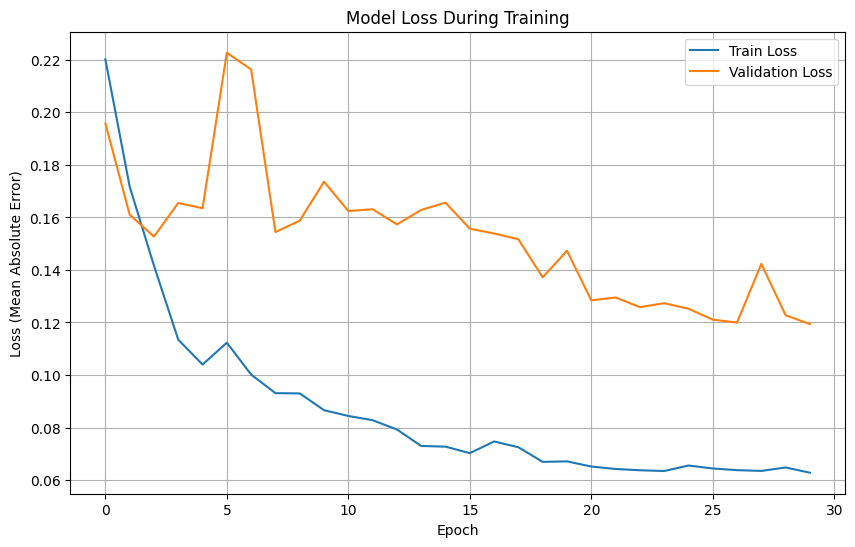


--- Making Sample Prediction ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


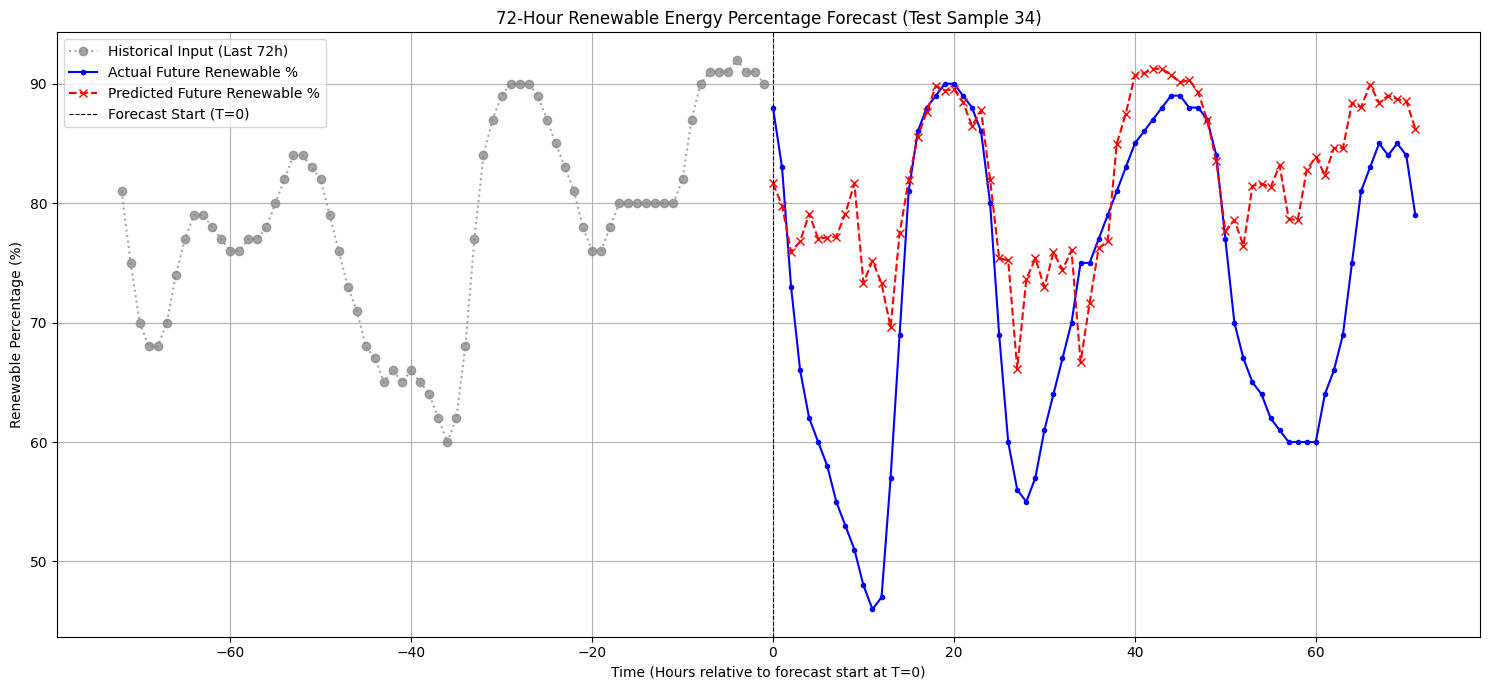

In [8]:
# Cell 7: Model Training, Evaluation, and Plotting
history = None # Initialize history
if solar_model and X_train.shape[0] > 0 and y_train.shape[0] > 0 and X_valid.shape[0] > 0 and y_valid.shape[0] > 0:
    print("\n--- Starting Model Training ---")
    solar_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    
    history = solar_model.fit(X_train, y_train,
                              validation_data=(X_valid, y_valid),
                              epochs=30,
                              batch_size=16, # Smaller batch size for smaller dataset
                              verbose=1)
                              

    # # Using more epochs, but with early stopping for practical training on limited data
    # history = solar_model.fit(X_train, y_train,
    #                           validation_data=(X_valid, y_valid),
    #                           epochs=50, # Increased epochs, but early stopping will likely trigger
    #                           batch_size=16, # Smaller batch size for smaller dataset
    #                           verbose=1,
    #                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

    # Model Evaluation
    if X_test.shape[0] > 0 and y_test.shape[0] > 0:
        print("\n--- Evaluating Model ---")
        test_loss, test_mae = solar_model.evaluate(X_test, y_test, verbose=0)
        print(f"Test MAE: {test_mae:.4f}")

        # Plotting Training Loss
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss During Training')
        plt.ylabel('Loss (Mean Absolute Error)')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()
    else:
        print("Not enough test data to evaluate the model.")

    # Make a Sample Prediction and Plot
    if len(X_test) > 0:
        print("\n--- Making Sample Prediction ---")
        sample_index = np.random.randint(0, len(X_test))
        sample_X_test = X_test[sample_index:sample_index+1]
        sample_y_true_scaled = y_test[sample_index]
        
        prediction_scaled = solar_model.predict(sample_X_test)
        
        sample_y_true_inversed = scaler.inverse_transform(sample_y_true_scaled.reshape(-1,1))
        prediction_inversed = scaler.inverse_transform(prediction_scaled.reshape(-1,1))
        
        plt.figure(figsize=(15, 7))
        time_axis_input = np.arange(-LOOK_BACK, 0)
        time_axis_output = np.arange(0, FORECAST_HORIZON)
        
        historical_input_scaled = X_test[sample_index, :, 0]
        historical_input_inversed = scaler.inverse_transform(historical_input_scaled.reshape(-1,1))
        plt.plot(time_axis_input, historical_input_inversed, label=f'Historical Input (Last {LOOK_BACK}h)', marker='o', linestyle=':', color='gray', alpha=0.7)
        
        plt.plot(time_axis_output, sample_y_true_inversed, label='Actual Future Renewable %', marker='.', color='blue')
        plt.plot(time_axis_output, prediction_inversed, label='Predicted Future Renewable %', marker='x', linestyle='--', color='red')
        
        plt.title(f'{FORECAST_HORIZON}-Hour Renewable Energy Percentage Forecast (Test Sample {sample_index})')
        plt.xlabel(f'Time (Hours relative to forecast start at T=0)')
        plt.ylabel('Renewable Percentage (%)')
        plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8, label='Forecast Start (T=0)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough test data to make and plot a sample prediction.")
else:
    if solar_model is None:
        print("Model was not built (likely due to lack of data).")
    else:
        print("CRITICAL: Not enough training or validation data to train the model. Please check data preparation steps.")

### Notes on the Model and Code

1.  **Data Source:** This notebook exclusively attempts to use `codegreen-core` (ENTSO-E) for data. There is no dummy data fallback if fetching fails or provides insufficient data.
2.  **Historical Data:** The script is now configured to fetch `DAYS_HISTORY = 31` (approximately 3 months) of past generation data for training. **This is a very small amount of data for the specified model and is highly likely to result in poor generalization and overfitting.**
3.  **Target Variable:** The `percentRenewable` column from `codegreen-core` is used.
4.  **Timezone Handling:** Basic timezone handling for `codegreen-core` data is included.
5.  **Model Architecture:** The CNN-LSTM architecture is as per your specification, adapted for sequence-to-sequence output.
6.  **Training:** Epochs are set to 50, but `EarlyStopping` (patience=5 on `val_loss`) is included, which will likely stop training much earlier given the limited data.
7.  **Feature Engineering:** This model **only** uses the past renewable percentage as input. For a practical model, incorporating exogenous variables (weather forecasts, calendar features, etc.) is crucial and would require significantly more data and feature engineering effort.
8.  **Low Hardware Requirement:** While the model architecture is defined, training it effectively to be lightweight and accurate on only ~3 months of data is a significant challenge. The 'low hardware requirement' for deployment usually implies a model that has learned well and can then potentially be optimized (e.g., quantization), which is hard to achieve with insufficient training data.
9.  **Error Handling Removed:** `try-except` blocks have been removed. If issues like missing packages or API failures occur, Python will raise an error and stop execution.


--- Final Model Evaluation on Test Set ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step 

Overall Test Set Metrics (on inverse-transformed data):
  Mean Absolute Error (MAE): 9.6218
  Mean Squared Error (MSE):  164.5016
  Root Mean Squared Error (RMSE): 12.8258


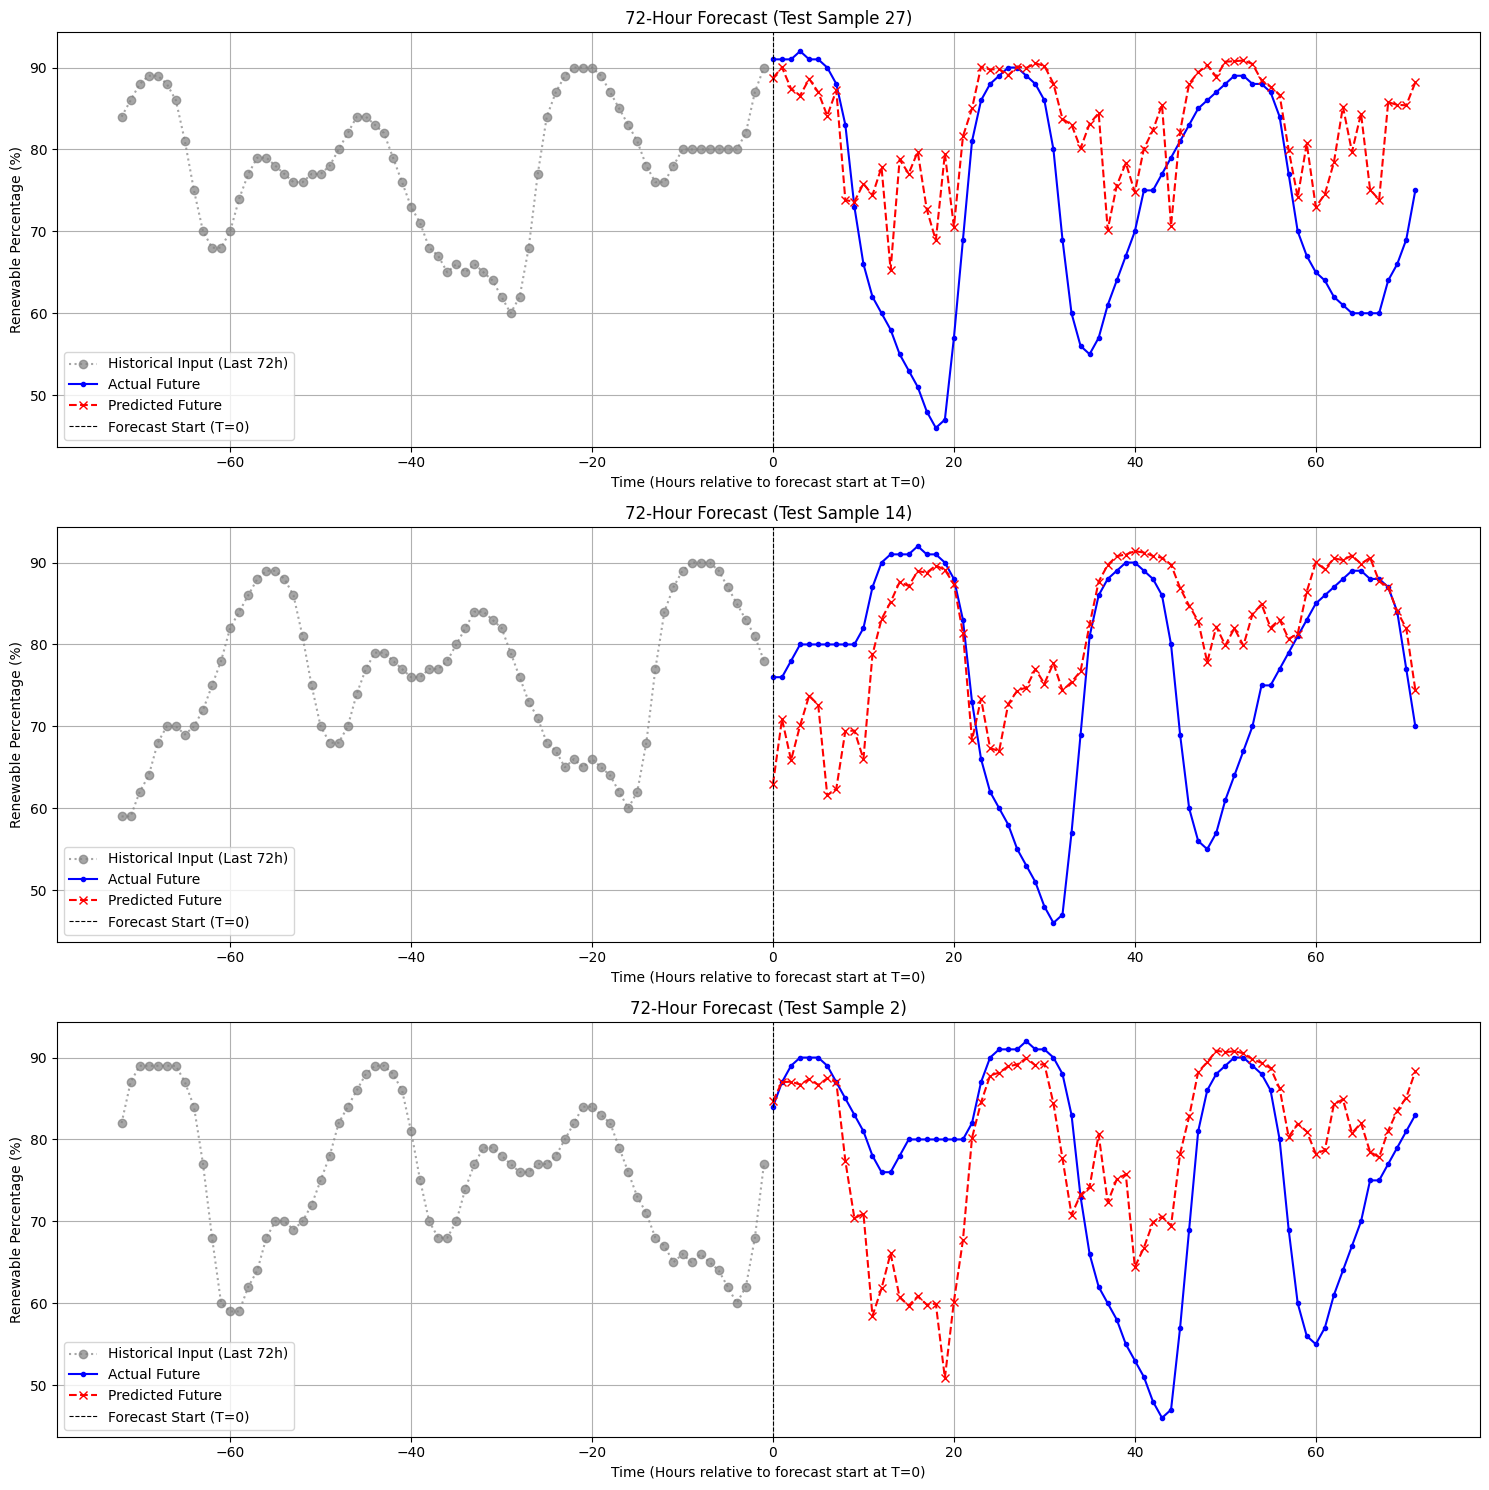

In [9]:
# Cell 8: Final Model Evaluation on Test Set (Corrected)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

if solar_model and X_test.shape[0] > 0 and y_test.shape[0] > 0:
    print("\n--- Final Model Evaluation on Test Set ---")
    # Make predictions on the entire test set
    y_pred_scaled = solar_model.predict(X_test)

    # Flatten the arrays to treat each predicted point independently for metric calculation
    y_test_flat_scaled = y_test.flatten().reshape(-1, 1)
    y_pred_flat_scaled = y_pred_scaled.flatten().reshape(-1, 1)

    y_test_inversed_flat = scaler.inverse_transform(y_test_flat_scaled).flatten()
    y_pred_inversed_flat = scaler.inverse_transform(y_pred_flat_scaled).flatten()

    # Calculate metrics
    mae_overall = mean_absolute_error(y_test_inversed_flat, y_pred_inversed_flat)
    mse_overall = mean_squared_error(y_test_inversed_flat, y_pred_inversed_flat)
    rmse_overall = np.sqrt(mse_overall)

    print(f"\nOverall Test Set Metrics (on inverse-transformed data):")
    print(f"  Mean Absolute Error (MAE): {mae_overall:.4f}")
    print(f"  Mean Squared Error (MSE):  {mse_overall:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse_overall:.4f}")

    # Optional: Plot a few examples of predictions vs actuals from the test set
    num_plots = min(3, len(X_test)) # Plot up to 3 examples
    if num_plots > 0:
        plt.figure(figsize=(15, 5 * num_plots))
        for i in range(num_plots):
            sample_idx_plot = np.random.randint(0, len(X_test)) # Pick a random sample
            
            # Get historical input for this sample
            historical_input_scaled_plot = X_test[sample_idx_plot, :, 0]
            historical_input_inversed_plot = scaler.inverse_transform(historical_input_scaled_plot.reshape(-1,1))
            
            # Get true future and predicted future for this sample
            y_true_scaled_plot = y_test[sample_idx_plot]
            y_pred_scaled_plot = y_pred_scaled[sample_idx_plot]
            
            y_true_inversed_plot = scaler.inverse_transform(y_true_scaled_plot.reshape(-1,1))
            y_pred_inversed_plot = scaler.inverse_transform(y_pred_scaled_plot.reshape(-1,1))
            
            time_axis_input_plot = np.arange(-LOOK_BACK, 0)
            time_axis_output_plot = np.arange(0, FORECAST_HORIZON)
            
            plt.subplot(num_plots, 1, i + 1)
            plt.plot(time_axis_input_plot, historical_input_inversed_plot, label=f'Historical Input (Last {LOOK_BACK}h)', marker='o', linestyle=':', color='gray', alpha=0.7)
            plt.plot(time_axis_output_plot, y_true_inversed_plot, label='Actual Future', marker='.', color='blue')
            plt.plot(time_axis_output_plot, y_pred_inversed_plot, label='Predicted Future', marker='x', linestyle='--', color='red')
            plt.title(f'{FORECAST_HORIZON}-Hour Forecast (Test Sample {sample_idx_plot})')
            plt.xlabel('Time (Hours relative to forecast start at T=0)')
            plt.ylabel('Renewable Percentage (%)')
            plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8, label='Forecast Start (T=0)')
            plt.legend()
            plt.grid(True)
            
        plt.tight_layout()
        plt.show()
    else:
        print("No samples available in the test set to plot.")
else:
    print("Model not trained or no test data available for final evaluation.")